# 1. Importing necessary Libraries

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn         
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from pickle import dump, load
import mlflow
import mlflow.sklearn
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 2. Importing Dataset

In [75]:
training_data = pd.read_csv('./Dataset/Training Data.csv')
training_data.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [76]:
test_data = pd.read_csv('./Dataset/Test Data.csv')
test_data.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


In [77]:
training_data.shape


(252000, 13)

In [78]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [79]:
test_data.shape

(28000, 12)

In [80]:
sample_data = pd.read_csv('./Dataset/Sample Prediction Dataset.csv')
sample_data.head()

,id,risk_flag
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0


# Merging the dataset
Since we have received our data in three different file, we can merge our data into a single file and work on it.

In [81]:
# Renaming columns in the test dataset
test_data.rename(columns = {'ID':'Id'}, inplace = True)

# Adding predicted risk flags from the sample prediction dataset
test_data['Risk_Flag']=sample_data['risk_flag']

# Concatenating training and test datasets
dataset = pd.concat([training_data, test_data], axis = 0, )

In [82]:
# Dropping the 'Id' column from the dataset
dataset.drop(['Id'], axis = 1, inplace = True)

# Adding a new 'Id' column with a range of values
dataset.insert(0, "Id", np.arange(0,280000))

# Setting the 'Id' column as the index
dataset.set_index('Id', inplace=True)

In [83]:
# Replace spaces with underscores in the 'Profession' columns
dataset['Profession'] = dataset['Profession'].apply(lambda x: x.replace(' ', '_'))

# Dropping the 'CITY' and 'STATE' Column from the dataset
dataset.drop(['CITY', 'STATE'], axis=1, inplace=True)

In [84]:
dataset.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,,,,,
0,1303834,23,3,single,rented,no,Mechanical_engineer,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,3,14,1


In [85]:
dataset.shape

(280000, 10)

In [86]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280000 entries, 0 to 279999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             280000 non-null  int64 
 1   Age                280000 non-null  int64 
 2   Experience         280000 non-null  int64 
 3   Married/Single     280000 non-null  object
 4   House_Ownership    280000 non-null  object
 5   Car_Ownership      280000 non-null  object
 6   Profession         280000 non-null  object
 7   CURRENT_JOB_YRS    280000 non-null  int64 
 8   CURRENT_HOUSE_YRS  280000 non-null  int64 
 9   Risk_Flag          280000 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.4+ MB


In [87]:
dataset.describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.800000e+05,280000.000000,280000.000000,280000.000000,280000.000000,280000.000000
mean,5.000361e+06,49.964132,10.088032,6.334418,11.997193,0.123532
std,2.876988e+06,17.070465,6.005066,3.646864,1.398907,0.329048
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.506726e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.003310e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


# Saving the file
We can save our merged file for later use.

In [88]:
dataset.to_csv('./Dataset/Merged_Dataset.csv', index=False)

# 3. Exploratory Data Analysis (EDA) and Data preprocessing
Lets check how many are defaulted on loan(Risk_Flag = 1) and how many paid?

In [89]:
defaulted = dataset['Risk_Flag'].sum()
total = dataset.shape[0]
print(f"The rate of people who defaulted is {defaulted/total * 100:.2f}%")
print(f"The rate of people who paid their loan is {(total - defaulted)/total * 100:.2f}%")

The rate of people who defaulted is 12.35%
The rate of people who paid their loan is 87.65%


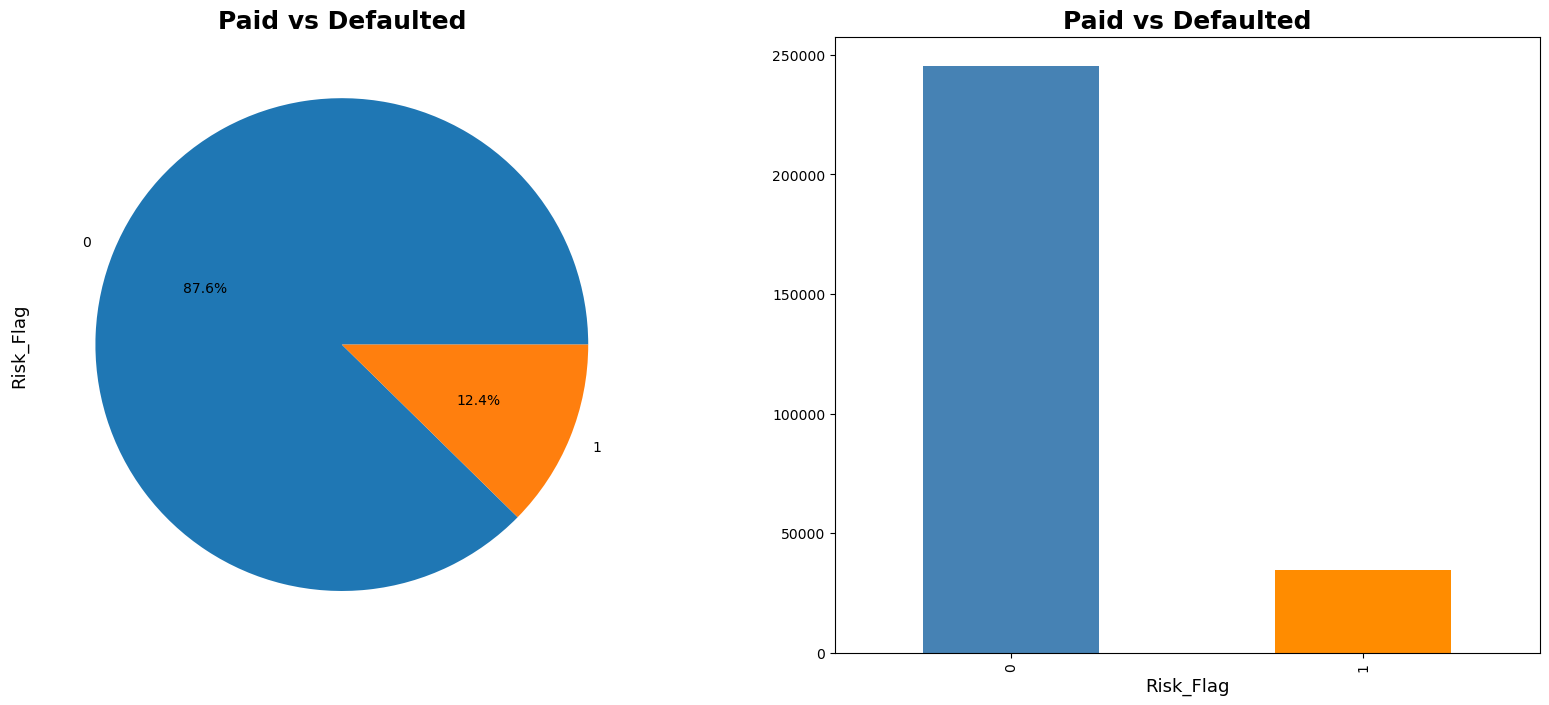

In [90]:
fig, (ax0, ax1) = plt.subplots(nrows= 1, ncols= 2, figsize = (20,8))

dataset['Risk_Flag'].value_counts().plot.pie(autopct = "%1.1f%%", ax = ax0)
ax0.set_title('Paid vs Defaulted', fontsize = 18, fontweight = 'bold')
ax0.set_ylabel('Risk_Flag',fontsize = 13)

dataset['Risk_Flag'].value_counts().plot(kind = 'bar', ax = ax1, color = ['steelBlue', 'DarkOrange'])
ax1.set_title('Paid vs Defaulted', fontsize = 18, fontweight = 'bold')
ax1.set_xlabel('Risk_Flag', fontsize = 13);

From above we can see that our 12.4% are defaulted and 87.6% are paid their loan.

# Correlation Between Features
Lets check if there is any correlation between the features

In [91]:
# Separate categorical and numerical columns
categorical_columns = [col for col in dataset.columns if dataset[col].dtype == 'object']
numerical_columns = [col for col in dataset.columns if col not in categorical_columns]

In [92]:
# Calculate the correlation matrix for numerical columns
numerical_corr_matrix = dataset[numerical_columns].corr()

# Select the column corresponding to the target variable
target_corr = numerical_corr_matrix['Risk_Flag']

# Sort the correlations in descending order
sorted_correlations = target_corr.abs().sort_values(ascending=False)

# Print the top 10 most correlated features
print(sorted_correlations.head(10))


Risk_Flag            1.000000
Experience           0.029902
Age                  0.019074
CURRENT_JOB_YRS      0.013923
CURRENT_HOUSE_YRS    0.003599
Income               0.002270
Name: Risk_Flag, dtype: float64


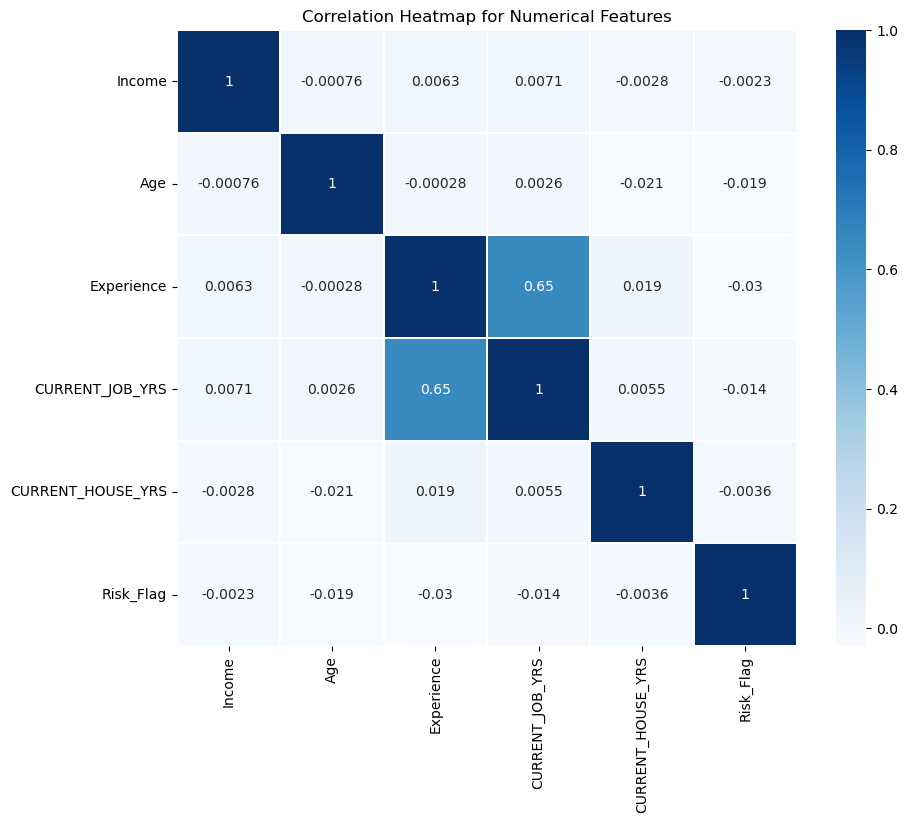

In [93]:
# Create the heatmap for numerical correlations
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_corr_matrix, linewidths=0.2, annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Numerical Features')
plt.show()


From above heatmap, we can see that `CURRENT_JOB_YRS` and `Experiece` has positive correlation.
We can either merge two feature or remove either one of them. We are removing `Experience` feature beacuse to predict on present context, `CURRENT_JOB_YRS` is more important.

In [94]:
dataset = dataset.drop('Experience', axis = 1)

# Income

In [95]:
dataset['Income'].describe().astype('int64')

count     280000
mean     5000361
std      2876987
min        10310
25%      2506726
50%      5003310
75%      7477502
max      9999938
Name: Income, dtype: int64

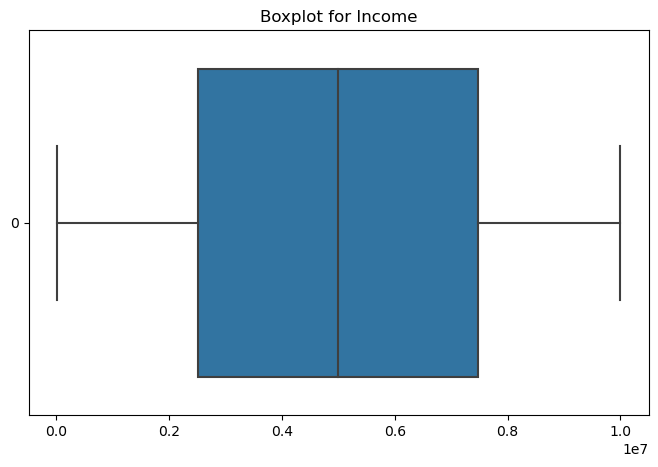

In [96]:
fig, ax = plt.subplots(figsize = (8,5))
sns.boxplot(data = dataset['Income'], ax = ax, orient='h');
ax.set_title('Boxplot for Income');

There is no outlier in our `Income` column.

In [97]:
Income_range = pd.qcut(dataset['Income'], 4).unique()
Income_range

[(10309.999, 2506726.0], (7477502.0, 9999938.0], (2506726.0, 5003310.0], (5003310.0, 7477502.0]]
Categories (4, interval[float64, right]): [(10309.999, 2506726.0] < (2506726.0, 5003310.0] < (5003310.0, 7477502.0] < (7477502.0, 9999938.0]]

In [98]:
bins = [10309, 2506726, 5003310, 7477502, 9999938]
labels = [0,1,2,3]

dataset['Cat_Income'] = pd.cut(dataset['Income'], labels = labels, bins = bins).astype('int64')
dataset = dataset.drop('Income', axis = 1)

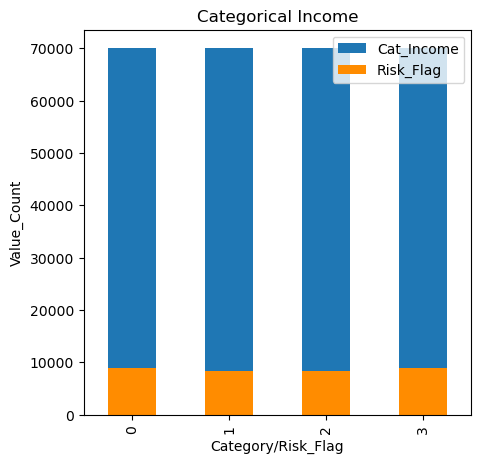

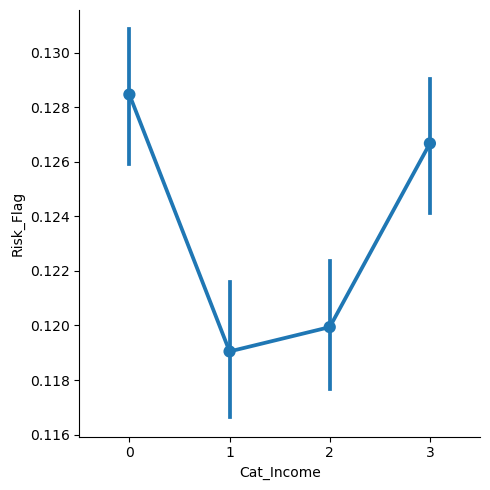

In [99]:
fig, ax = plt.subplots(figsize = (5,5))
dataset['Cat_Income'].value_counts(sort=False).plot.bar(ax = ax, label = 'Cat_Income')
dataset.groupby('Cat_Income')['Risk_Flag'].sum().plot.bar(ax = ax,color = 'DarkOrange', label = 'Risk_Flag')

ax.legend()
ax.set_title('Categorical Income')
ax.set_xlabel('Category/Risk_Flag')
ax.set_ylabel('Value_Count')

sns.catplot(x='Cat_Income', y = 'Risk_Flag', data = dataset, kind = 'point');

In [100]:
pd.crosstab(dataset['Cat_Income'], dataset['Risk_Flag'], margins=True)

Risk_Flag,0,1,All
Cat_Income,,,
0,61024,8995,70019
1,61671,8334,70005
2,61605,8396,70001
3,61111,8864,69975
All,245411,34589,280000


In [101]:
print(f'The rate of people defaulted on loan on each category with corresponding values are: ')
print(f'O : {8995/70019*100:.2f}% (8995)')
print(f'1 : {8334/70005*100:.2f}% (8334)')
print(f'2 : {8396/70001*100:.2f}% (8396)')
print(f'3 : {8864/69975*100:.2f}% (8864)')

The rate of people defaulted on loan on each category with corresponding values are: 
O : 12.85% (8995)
1 : 11.90% (8334)
2 : 11.99% (8396)
3 : 12.67% (8864)


From the above, we can conclude that the "category 0" has a greater chance of defaulting on its loan. However, people with high incomes are also not repaying their loans, raising the possibility of fraud. There are also other factors we have to check before reaching this conclusion.

In [102]:
dataset.isna().sum()

Age                  0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
Cat_Income           0
dtype: int64

# Age

In [103]:
dataset['Age'].describe()

count    280000.000000
mean         49.964132
std          17.070465
min          21.000000
25%          35.000000
50%          50.000000
75%          65.000000
max          79.000000
Name: Age, dtype: float64

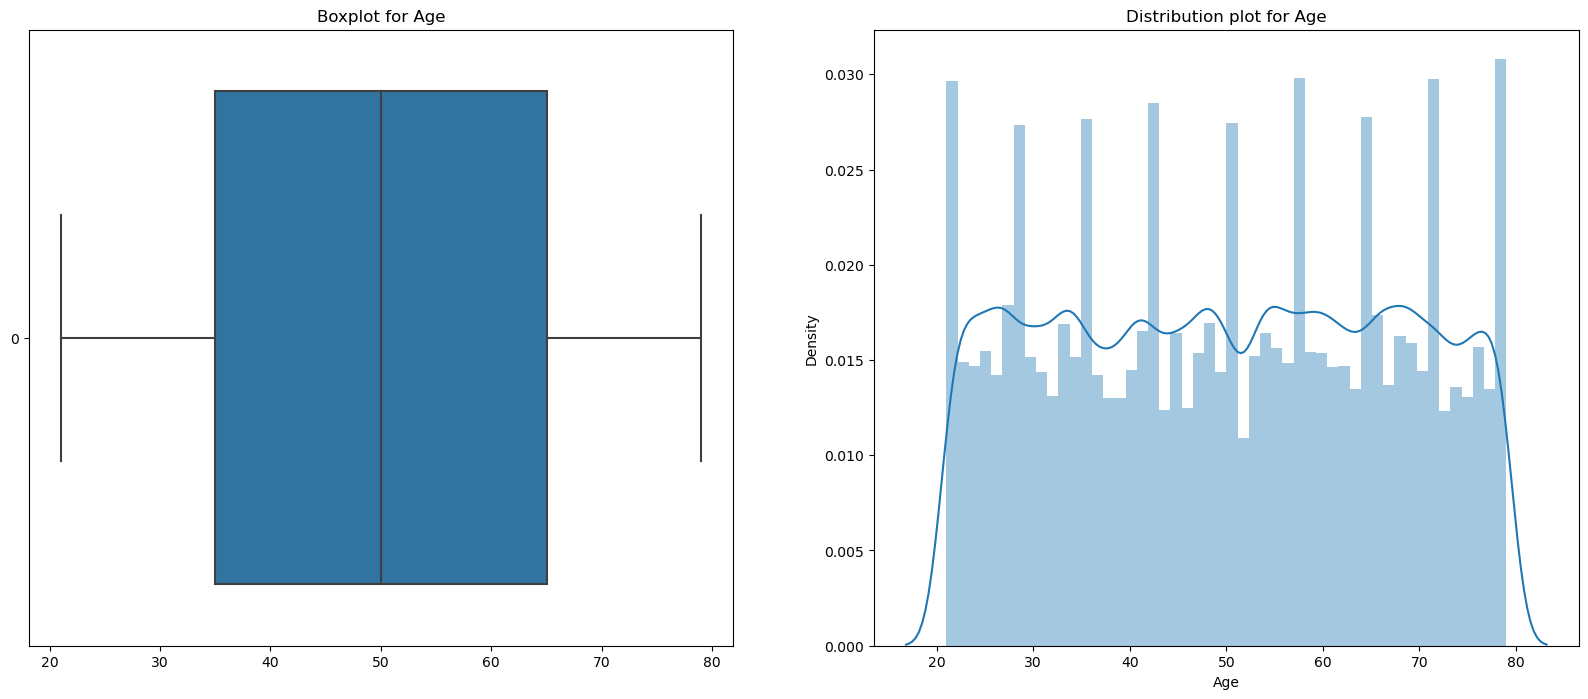

In [104]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols= 2, figsize = (20,8))
sns.boxplot(data = dataset['Age'], ax = ax0, orient='h')
sns.distplot(dataset['Age'], ax = ax1)

ax0.set_title('Boxplot for Age');
ax1.set_title('Distribution plot for Age');

There is no outlier in Age. There is no outlier in this age. And the age groups are almost uniformly distributed. Lets change our age group into smaller categorical group.

In [105]:
Age_range = pd.qcut(dataset['Age'], 5).unique()
Age_range

[(20.999, 32.0], (32.0, 44.0], (56.0, 68.0], (44.0, 56.0], (68.0, 79.0]]
Categories (5, interval[float64, right]): [(20.999, 32.0] < (32.0, 44.0] < (44.0, 56.0] < (56.0, 68.0] < (68.0, 79.0]]

In [106]:
bins = [20,32,44,56,68,79]
labels = [0,1,2,3,4]

dataset['Cat_Age'] = pd.cut(dataset['Age'], labels = labels, bins = bins).astype('int64')
dataset = dataset.drop('Age', axis = 1)

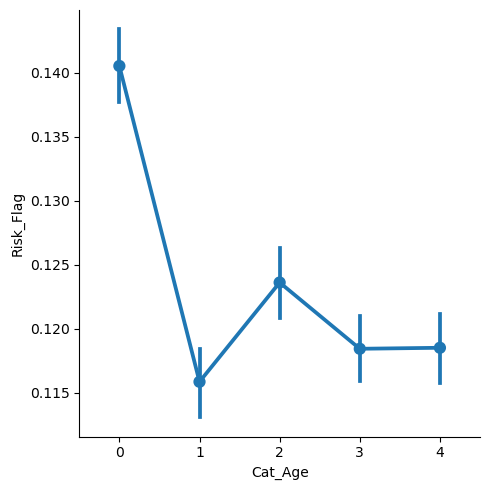

In [107]:
sns.catplot(x='Cat_Age', y = 'Risk_Flag', data = dataset, kind = 'point');

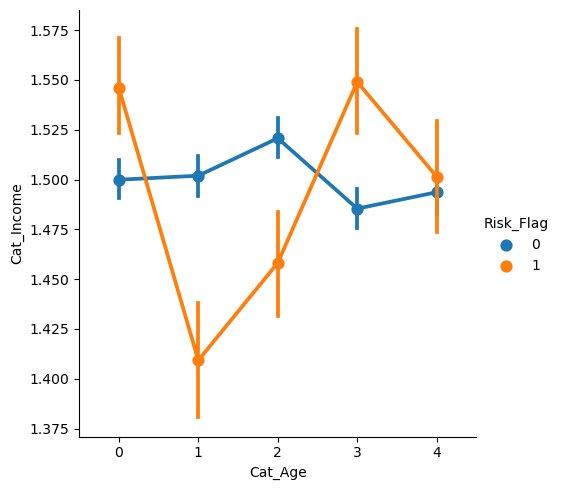

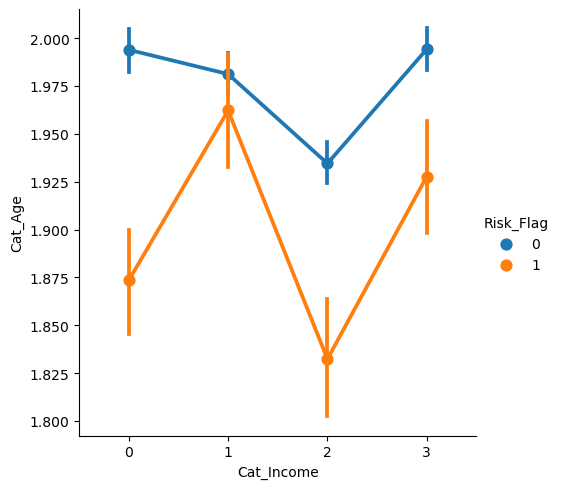

In [108]:
sns.catplot(data = dataset, x = 'Cat_Age', y = 'Cat_Income',hue = 'Risk_Flag', kind='point')
sns.catplot(data = dataset, x = 'Cat_Income', y = 'Cat_Age',hue = 'Risk_Flag', kind='point');

From the above graph, we can conclude that the age groups in the lower category are more risky to give loans to.

# Married/Single

In [109]:
dataset['Married/Single'].value_counts()

Married/Single
single     251442
married     28558
Name: count, dtype: int64

In [110]:
pd.crosstab(dataset['Married/Single'], dataset['Risk_Flag'], margins=True)

Risk_Flag,0,1,All
Married/Single,,,
married,25548,3010,28558
single,219863,31579,251442
All,245411,34589,280000


In [111]:
print(f'The rate of people defaulted on loan on each category with corresponding values are: ')
print(f'Married : {3010/28558*100:.2f}% (3010)')
print(f'Single : {31579/251442*100:.2f}% (31579)')

The rate of people defaulted on loan on each category with corresponding values are: 
Married : 10.54% (3010)
Single : 12.56% (31579)


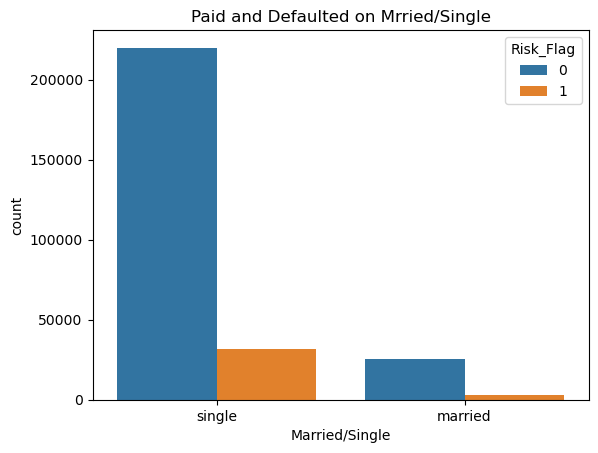

In [112]:
sns.countplot(data=dataset, x = 'Married/Single', hue = 'Risk_Flag').set(title = 'Paid and Defaulted on Mrried/Single');

From the above information, we can conclude that single people have more chances of defaulting on a loan.

# House_Ownership

In [113]:
dataset['House_Ownership'].value_counts()

House_Ownership
rented          257703
owned            14348
norent_noown      7949
Name: count, dtype: int64

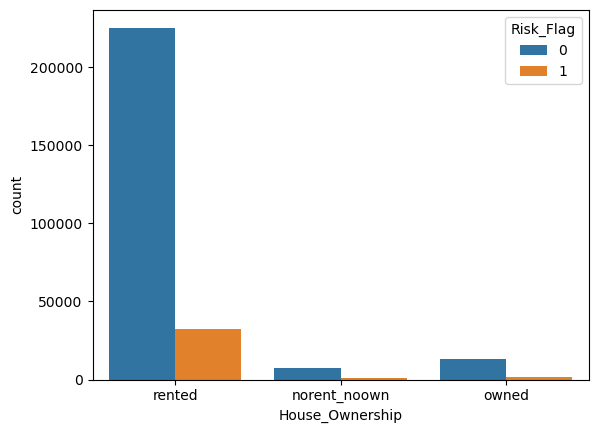

In [114]:
sns.countplot(data = dataset, x='House_Ownership', hue = 'Risk_Flag');

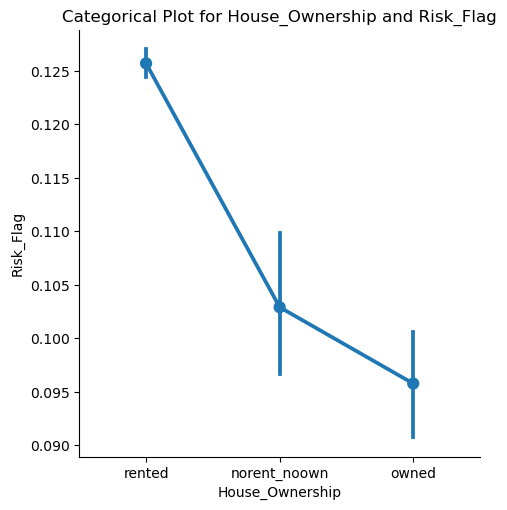

In [115]:
sns.catplot(x='House_Ownership', y = 'Risk_Flag', data = dataset, kind = 'point').set(title = 'Categorical Plot for House_Ownership and Risk_Flag');

From the above bar graph and categorical plot, people on rent tend to take more loans, and they are also highly likely to default.

# Car_Ownership

In [116]:
dataset['Car_Ownership'].value_counts()

Car_Ownership
no     195625
yes     84375
Name: count, dtype: int64

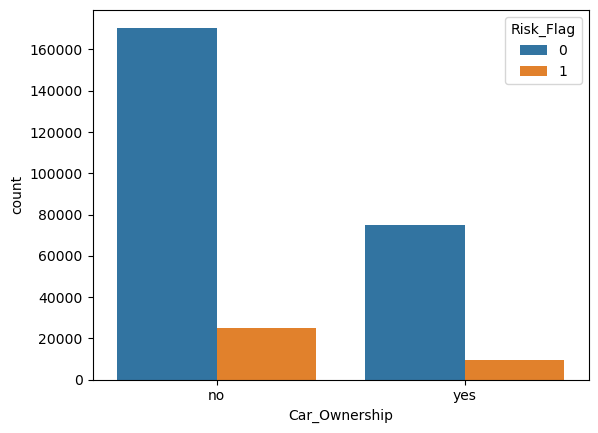

In [117]:
sns.countplot(data = dataset, x = 'Car_Ownership', hue = 'Risk_Flag');

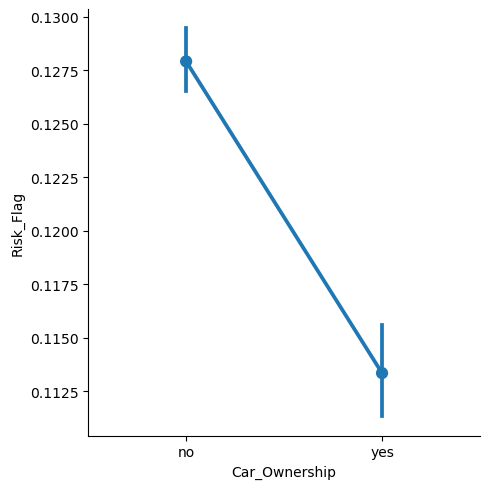

In [118]:
sns.catplot(data = dataset, x = 'Car_Ownership', y = 'Risk_Flag', kind='point');

We can see that the number of people who do not own a car is high, and they are also more likely to default on their loans. Let's check for both car and house ownership to be clear.

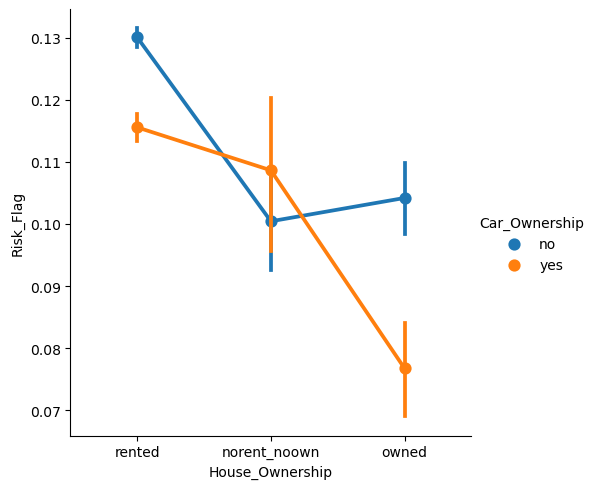

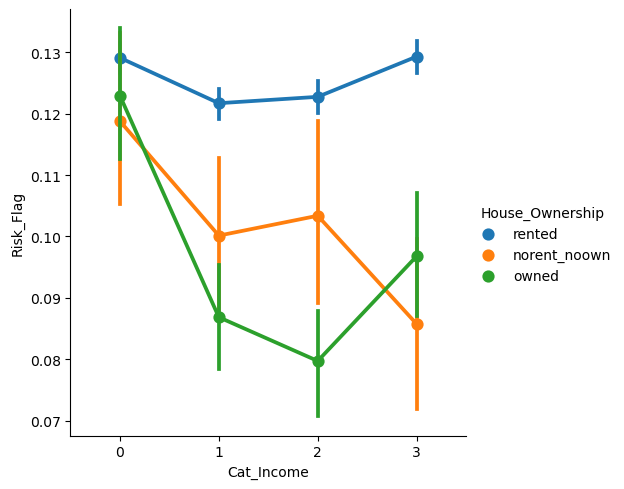

In [119]:
sns.catplot(data = dataset, x = 'House_Ownership', y = 'Risk_Flag',hue = 'Car_Ownership', kind='point')
sns.catplot(data = dataset, x = 'Cat_Income', y = 'Risk_Flag',hue = 'House_Ownership', kind='point');

From the above graph, we can conclude that rich people who own both a car and a house are less likely to default, and vice versa.

# Profession

In [120]:
print(f'The total number of unique professions in dataset is {len(dataset.Profession.unique())}.')

The total number of unique professions in dataset is 51.


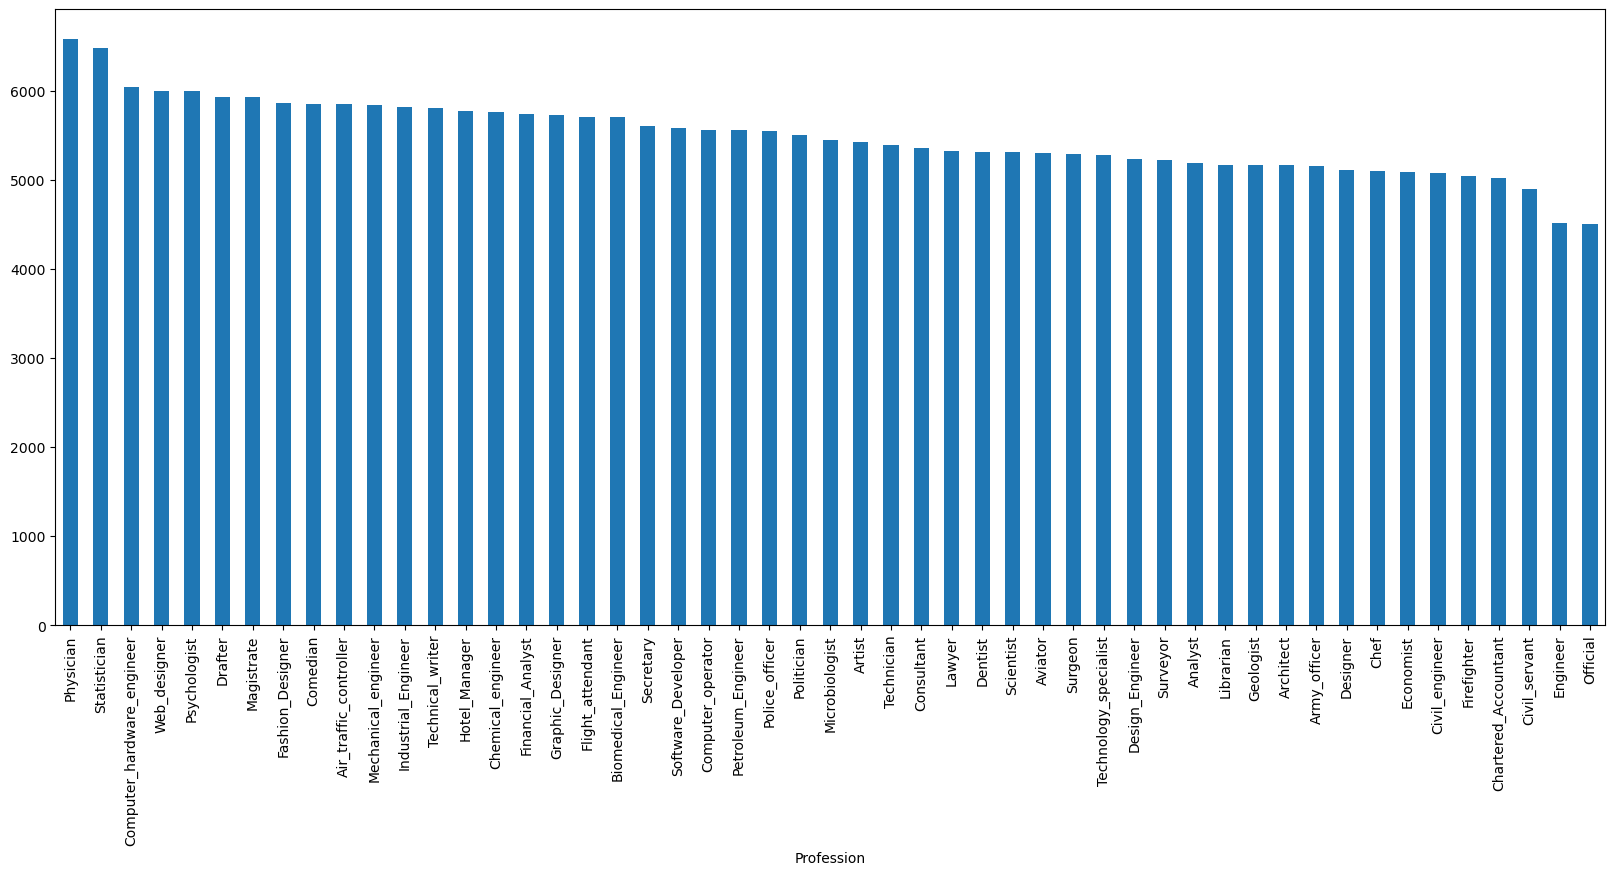

In [121]:
fig, ax = plt.subplots(figsize = (20,8))
dataset['Profession'].value_counts().plot.bar();

In [122]:
pd.crosstab(dataset['Profession'], dataset['Risk_Flag'], margins = True).sort_values(by=1, ascending=False).head()

Risk_Flag,0,1,All
Profession,,,
All,245411,34589,280000
Police_officer,4655,896,5551
Software_Developer,4753,829,5582
Air_traffic_controller,5069,786,5855
Army_officer,4376,786,5162


From the above information, physicians apply for loans more than other professions, and police officers are the most likely to have defaulted on their loans.

# Current Job Year

In [123]:
pd.crosstab(dataset['Risk_Flag'], dataset['CURRENT_JOB_YRS'])

CURRENT_JOB_YRS,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Risk_Flag,,,,,,,,,,,,,,,
0,10579,10881,10263,28913,27843,24544,22858,19594,18492,16949,15433,13117,10461,8732,6752
1,1713,1960,2069,3794,3599,3341,3210,2624,2438,2131,2106,2023,1255,1406,920


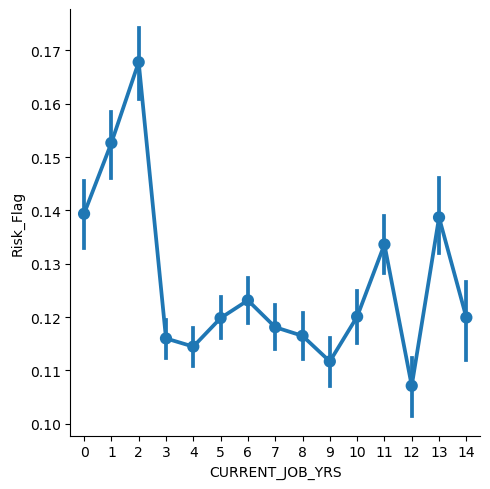

In [124]:
sns.catplot(data = dataset, x = 'CURRENT_JOB_YRS', y = 'Risk_Flag', kind = 'point');

From the above plot, we can say that when people just started working, they were not able to pay their loan and defaulted, but after a certain amount of time (3 years), many people were able to pay their loan and the default rate decreased.

# Current House Year

In [125]:
pd.crosstab(dataset['Risk_Flag'], dataset['CURRENT_HOUSE_YRS'])

CURRENT_HOUSE_YRS,10,11,12,13,14
Risk_Flag,,,,,
0,47350,50363,50633,49292,47773
1,6770,7229,7022,6928,6640


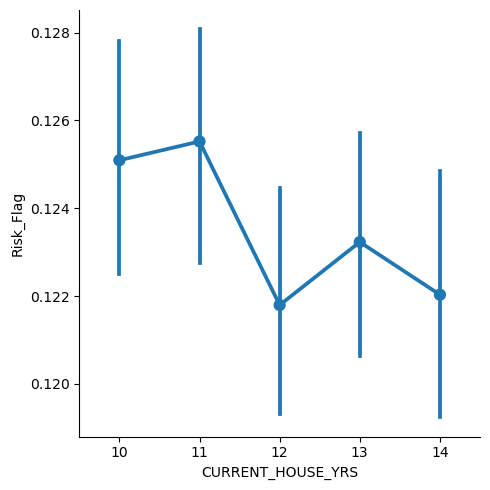

In [126]:
sns.catplot(data = dataset, x = 'CURRENT_HOUSE_YRS', y = 'Risk_Flag', kind = 'point');

From the above graph, we can conclude that loans are only given to those who have lived in the same residence for more than 10 years, and the default rate decreases as the number of current house years decreases.

# Converting categorical columns to numerical
We converted each categorical column to numerical column and also saved label encoder object for each feature for deploy part.

In [127]:
import os
from pickle import dump

# Create the 'Models' directory if it doesn't exist
models_dir = './Models'
os.makedirs(models_dir, exist_ok=True)

# Rest of code to create and save encoders
categorical_columns = [i for i in dataset.columns if dataset[i].dtype == 'object']
encoders = {}

for column in categorical_columns:
    encoder = LabelEncoder()
    encoder.fit(dataset[column])
    encoders[column] = encoder

with open(os.path.join(models_dir, 'encoders.pkl'), 'wb') as file:
    dump(encoders, file)

for column in categorical_columns:
    label_encoder = encoders[column]
    dataset[column] = label_encoder.transform(dataset[column])


In [128]:
dataset.head()

,Married/Single,House_Ownership,Car_Ownership,Profession,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Cat_Income,Cat_Age
Id,,,,,,,,,
0,1,2,0,33,3,13,0,0,0
1,1,2,0,43,9,13,0,3,1
2,0,2,0,47,4,10,0,1,3
3,1,2,1,43,2,12,1,2,1
4,1,2,0,11,3,14,1,2,2


# Checking correlation of the final dataset

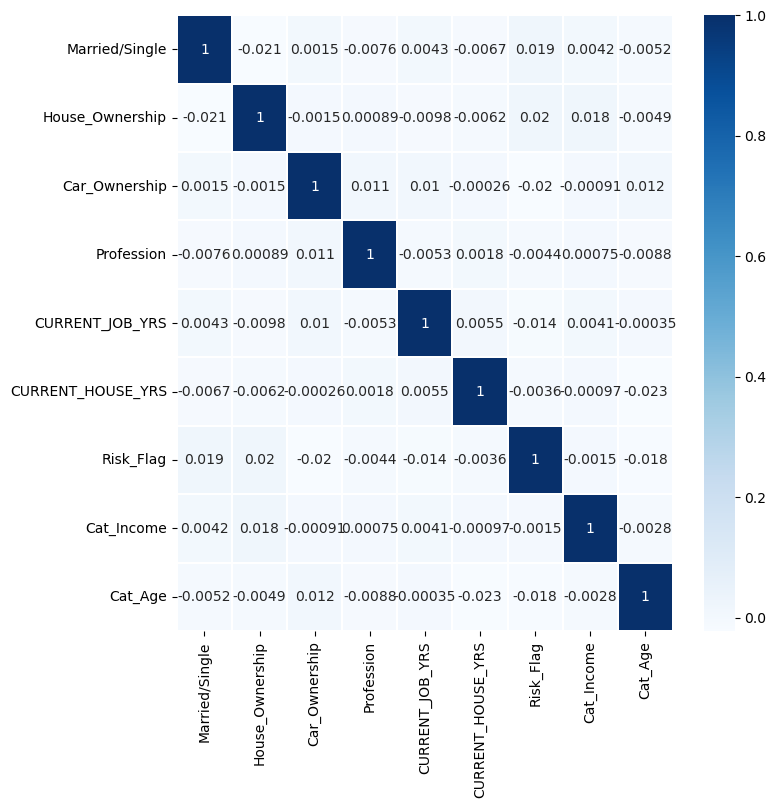

In [129]:
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(dataset.corr(), linewidths=0.2, cmap='Blues', annot=True, ax = ax);

There is no correlation between features in our dataset. We can now proceed to the next step. 

# 4. Balancing our dataset
As we've seen earlier, our dataset is not balanced. It contain only **12.4%** on defaulted and **87.4%** on not defaulted. 
Balancing a dataset is important to prevent biases and improve the overall accuracy and generalization ability of machine learning models.
There are different ways to handle imbalanced dataset:
* OverSampling
* UnderSampling
* Combination of Oversampling and undersampling
* Ensemble
* Batching

We are using combination of both oversampling and undersampling technique `(SMOTEENN)` to balance our dataset.
`SMOTEENN` is a method for balancing imbalanced datasets that combines the oversampling technique `SMOTE (Synthetic Minority Over-sampling Technique)` and the undersampling technique `Edited Nearest Neighbors (ENN)`.

In [130]:
X = dataset.drop('Risk_Flag', axis = 1)
y = dataset['Risk_Flag']

SMOTEENN = imblearn.combine.SMOTEENN()

print(f'Original dataset shape is {y.shape[0]}')

#X_res, y_res = SMOTEENN.fit_resample(X, y)

#X_res.to_csv('./Dataset/balanced_feature.csv', index=False)
#y_res.to_csv('./Dataset/balanced_target.csv', index=False)

X_res = pd.read_csv('./Dataset/balanced_feature.csv')
y_res = pd.read_csv('./Dataset/balanced_target.csv')

print(f'After undersample dataset shape is {y_res.shape[0]}')

Original dataset shape is 280000
After undersample dataset shape is 321073


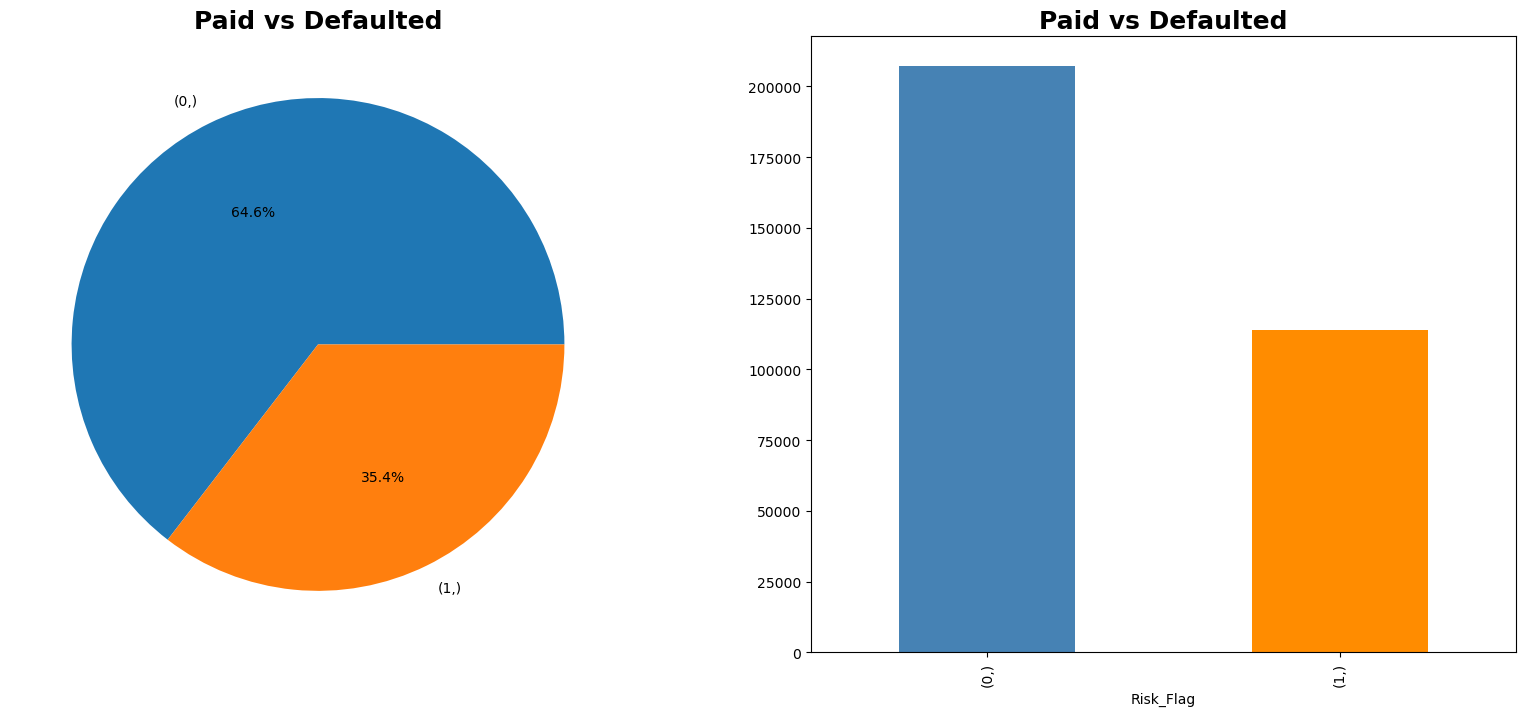

In [131]:
fig, (ax0, ax1) = plt.subplots(nrows= 1, ncols= 2, figsize = (20,8))

y_res.value_counts().plot.pie(autopct = "%1.1f%%", ax = ax0)
ax0.set_title('Paid vs Defaulted', fontsize = 18, fontweight = 'bold')
ax0.set_ylabel('',fontsize = 13)

y_res.value_counts().plot(kind = 'bar', ax = ax1, color = ['steelBlue', 'DarkOrange'])
ax1.set_title('Paid vs Defaulted', fontsize = 18, fontweight = 'bold');

Although our data is not balanced, we can work on it better than the previous dataset.

# 5. Model Training and Testing
Also, let's create function to evaluate the model.

In [132]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparision on y_true labels vs. y_preds labels on classification.
    """
    accuracy = metrics.accuracy_score(y_true, y_preds)
    precision = metrics.precision_score(y_true, y_preds)
    recall = metrics.recall_score(y_true, y_preds)
    f1 = metrics.f1_score(y_true, y_preds)
    metric_dict = {'accuracy':round(accuracy, 2),
                   'precision':round(precision, 2),
                   'recall':round(recall, 2),
                   'f1':round(f1, 2)}
    print(f'Accuracy : {accuracy * 100:.2f}%')
    print(f'Precision : {precision:.2f}')
    print(f'Recall : {recall:.2f}')
    print(f'F1 score : {f1:.2f}')
    
    return metric_dict

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

# 5.1. Decision Tree

In [134]:
from sklearn.tree import DecisionTreeClassifier

# Load the saved model
loaded_model = mlflow.sklearn.load_model("./Models/decisiontree")

with mlflow.start_run(run_name="decisiontree"):
    decisiontree = DecisionTreeClassifier(random_state=10)
    decisiontree.fit(X_train, y_train)

    y_pred = decisiontree.predict(X_test)
    result = evaluate_preds(y_test, y_pred)

    cross_val_scores = cross_val_score(decisiontree, X_res, y_res, cv=5, scoring='accuracy')
    print(f'Cross-Validation score: {np.mean(cross_val_scores)*100:.2f}')
    
    mlflow.log_param("random_state", 10)
    mlflow.log_metric("accuracy", result['accuracy'])
    mlflow.log_metric("precision", result['precision'])
    mlflow.log_metric("recall", result['recall'])
    mlflow.log_metric("f1-score", result['f1'])
    mlflow.sklearn.log_model(decisiontree, "model")
    #mlflow.sklearn.save_model(decisiontree, "./Models/decisiontree")

Accuracy : 98.81%
Precision : 0.97
Recall : 0.99
F1 score : 0.98
Cross-Validation score: 97.32


In [135]:
print(f'The accuracy of Decision Tree on Train_set is {metrics.accuracy_score(y_train, decisiontree.predict(X_train))*100:.2f}%.')
print(f'The accuracy of Decision Tree on Test_set is {metrics.accuracy_score(y_test, decisiontree.predict(X_test))*100:.2f}%.')

The accuracy of Decision Tree on Train_set is 100.00%.
The accuracy of Decision Tree on Test_set is 98.81%.


# 5.2. Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier

# Load the saved model
loaded_model = mlflow.sklearn.load_model("./Models/randomforest")

with mlflow.start_run(run_name="randomforest"):
    randomforest = RandomForestClassifier(random_state=10)
    randomforest.fit(X_train, y_train)

    y_pred = randomforest.predict(X_test)
    result = evaluate_preds(y_test, y_pred);

    cross_val_scores = cross_val_score(randomforest, X_res, y_res, cv=5, scoring='accuracy')
    print(f'Cross-Validation score: {np.mean(cross_val_scores)*100:.2f}')
    
    mlflow.log_param("random_state", 10)
    mlflow.log_metric("accuracy", result['accuracy'])
    mlflow.log_metric("precision", result['precision'])
    mlflow.log_metric("recall", result['recall'])
    mlflow.log_metric("f1-score", result['f1'])
    mlflow.sklearn.log_model(randomforest, "model")
    #mlflow.sklearn.save_model(randomforest, "./Models/randomforest")

Accuracy : 98.97%
Precision : 0.98
Recall : 0.99
F1 score : 0.99
Cross-Validation score: 97.27


In [137]:
print(f'The accuracy of Random Forest on Train_set is {metrics.accuracy_score(y_train, randomforest.predict(X_train))*100:.2f}%.')
print(f'The accuracy of Random Forest on Test_set is {metrics.accuracy_score(y_test, randomforest.predict(X_test))*100:.2f}%.')

The accuracy of Random Forest on Train_set is 100.00%.
The accuracy of Random Forest on Test_set is 98.97%.


# 5.3. XGBoost

In [138]:
from xgboost import XGBClassifier

# Load the saved model
loaded_model = mlflow.sklearn.load_model("./Models/xgb")

with mlflow.start_run(run_name="xgb"):
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    result = evaluate_preds(y_test, y_pred);

    cross_val_scores = cross_val_score(xgb, X_res, y_res, cv=5, scoring='accuracy')
    print(f'Cross-Validation score: {np.mean(cross_val_scores)*100:.2f}')
    
    mlflow.log_param("random_state", 10)
    mlflow.log_metric("accuracy", result['accuracy'])
    mlflow.log_metric("precision", result['precision'])
    mlflow.log_metric("recall", result['recall'])
    mlflow.log_metric("f1-score", result['f1'])
    mlflow.sklearn.log_model(xgb, "model")
    #mlflow.sklearn.save_model(xgb, "./Models/xgb")

Accuracy : 89.02%
Precision : 0.92
Recall : 0.76
F1 score : 0.83
Cross-Validation score: 88.85


In [139]:
print(f'The accuracy of XGBoost on Train_set is {metrics.accuracy_score(y_train, xgb.predict(X_train))*100:.2f}%.')
print(f'The accuracy of XGboost on Test_set is {metrics.accuracy_score(y_test, xgb.predict(X_test))*100:.2f}%.')

The accuracy of XGBoost on Train_set is 89.37%.
The accuracy of XGboost on Test_set is 89.02%.


# 5.4. Gradient Boosting

In [140]:
from sklearn.ensemble import GradientBoostingClassifier
# Load the saved model
loaded_model = mlflow.sklearn.load_model("./Models/gradientboosting")

with mlflow.start_run(run_name="gradientboosting"):
    gradientboosting = GradientBoostingClassifier(random_state=10)
    gradientboosting.fit(X_train, y_train)

    y_pred = gradientboosting.predict(X_test)
    result = evaluate_preds(y_test, y_pred);

    cross_val_scores = cross_val_score(gradientboosting, X_res, y_res, cv=5, scoring='accuracy')
    print(f'Cross-Validation score: {np.mean(cross_val_scores)*100:.2f}')
    
    mlflow.log_param("random_state", 10)
    mlflow.log_metric("accuracy", result['accuracy'])
    mlflow.log_metric("precision", result['precision'])
    mlflow.log_metric("recall", result['recall'])
    mlflow.log_metric("f1-score", result['f1'])
    mlflow.sklearn.log_model(gradientboosting, "model")
    #mlflow.sklearn.save_model(gradientboosting, "./Models/gradientboosting")

Accuracy : 68.04%
Precision : 0.64
Recall : 0.23
F1 score : 0.34
Cross-Validation score: 68.27


In [141]:
print(f'The accuracy of Gradient Boosting on Train_set is {metrics.accuracy_score(y_train, gradientboosting.predict(X_train))*100:.2f}%.')
print(f'The accuracy of Gradient Boosting on Test_set is {metrics.accuracy_score(y_test, gradientboosting.predict(X_test))*100:.2f}%.')

The accuracy of Gradient Boosting on Train_set is 68.09%.
The accuracy of Gradient Boosting on Test_set is 68.04%.


# 5.5. Logistic Regression

In [142]:
from sklearn.linear_model import LogisticRegression

# Load the saved model
loaded_model = mlflow.sklearn.load_model("./Models/logistic_regression")

import mlflow
import mlflow.sklearn

with mlflow.start_run(run_name="logistic_regression"):
    logistic_regression = LogisticRegression(random_state=10)
    logistic_regression.fit(X_train, y_train)

    y_pred = logistic_regression.predict(X_test)
    result = evaluate_preds(y_test, y_pred)

    cross_val_scores = cross_val_score(logistic_regression, X_res, y_res, cv=5, scoring='accuracy')
    print(f'Cross-Validation score: {np.mean(cross_val_scores)*100:.2f}')
    
    mlflow.log_param("random_state", 10)
    mlflow.log_metric("accuracy", result['accuracy'])
    mlflow.log_metric("precision", result['precision'])
    mlflow.log_metric("recall", result['recall'])
    mlflow.log_metric("f1-score", result['f1'])
    mlflow.sklearn.log_model(logistic_regression, "model")
    #mlflow.sklearn.save_model(logistic_regression, "./Models/logistic_regression")

Accuracy : 64.54%
Precision : 0.50
Recall : 0.10
F1 score : 0.16
Cross-Validation score: 64.46


In [143]:
print(f'The accuracy of Logistic Regression on Train_set is {metrics.accuracy_score(y_train, logistic_regression.predict(X_train))*100:.2f}%.')
print(f'The accuracy of Logistic Regression on Test_set is {metrics.accuracy_score(y_test, y_pred)*100:.2f}%.')

The accuracy of Logistic Regression on Train_set is 64.37%.
The accuracy of Logistic Regression on Test_set is 64.54%.


From the above 5 models, we found that Decision Tree and RandomForest is working good but they seems to be overfitting. Logistic Regression and Gradient Boosting is not giving the good result. XGBoost is giving a good result but with a less recall.

# 6. Hyperparameter Tuning
The next step is to hyperparameter tuning. We can hyperparameter tune two models from above: Random Forest and XGBoost.

**Hyperparameter tuning Random Forest**

In [144]:
# Load the saved model
loaded_model = mlflow.sklearn.load_model("./Models/final_randomforest")

grid = {
    'n_estimators': [50, 80, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5]
}


with mlflow.start_run(run_name="final_randomforest"):
    gd = GridSearchCV(estimator=randomforest, param_grid=grid, cv = 5, verbose=2)
    gd.fit(X_train, y_train)
    best_param = gd.best_params_
    print(best_param)
    
    final_randomforest = gd.best_estimator_
    y_pred = final_randomforest.predict(X_test)

    result = evaluate_preds(y_test, y_pred);
    
    for param in best_param:
        mlflow.log_param(param, best_param[param])
    mlflow.log_metric("accuracy", result['accuracy'])
    mlflow.log_metric("precision", result['precision'])
    mlflow.log_metric("recall", result['recall'])
    mlflow.log_metric("f1-score", result['f1'])
    mlflow.sklearn.log_model(final_randomforest, "model")
    #mlflow.sklearn.save_model(final_randomforest, "./Models/final_randomforest")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   8.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   8.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   8.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   8.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   9.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=80; total time=  13.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=80; total time=  12.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=80; total time=  12.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=80; total time=  12.4s
[CV] END max_depth=30, max_features=sqrt, min_s

[CV] END max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=80; total time=  12.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=80; total time=  12.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=80; total time=  12.7s
[CV] END max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  15.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  15.6s
[CV] END max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  15.7s
[CV] END max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  16.0s
[CV] END max_depth=40, max_features=log2, min_samples_split=2, n_estimators=50; total time=   9.2s
[CV] END max_depth=40, max_features=log2, min_samples_split=2, n_estimators=50; total time=   8.7s
[CV] 

[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=50; total time=   9.1s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=50; total time=   9.3s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=50; total time=   9.1s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=50; total time=   9.1s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=50; total time=   9.1s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=80; total time=  14.6s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=80; total time=  14.6s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=80; total time=  14.7s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=80; total time=  14.6s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=80; total time=  14.6s
[CV] END m

[CV] END max_depth=70, max_features=sqrt, min_samples_split=2, n_estimators=80; total time=  12.8s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=2, n_estimators=80; total time=  14.9s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  17.9s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  19.9s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  16.3s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  16.3s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  16.2s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   8.0s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   7.9s
[CV] END max_depth=70, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   8.0s
[CV] 

[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=50; total time=   9.2s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=50; total time=   9.2s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=50; total time=   9.3s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=50; total time=   9.3s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=80; total time=  14.7s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=80; total time=  14.6s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=80; total time=  14.8s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=80; total time=  14.8s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=80; total time=  15.1s
[CV] END max_depth=80, max_features=log2, min_samples_split=2, n_estimators=100; total time=  18.4s
[CV] END 

[CV] END max_depth=90, max_features=log2, min_samples_split=5, n_estimators=80; total time=  14.7s
[CV] END max_depth=90, max_features=log2, min_samples_split=5, n_estimators=100; total time=  18.3s
[CV] END max_depth=90, max_features=log2, min_samples_split=5, n_estimators=100; total time=  18.2s
[CV] END max_depth=90, max_features=log2, min_samples_split=5, n_estimators=100; total time=  18.2s
[CV] END max_depth=90, max_features=log2, min_samples_split=5, n_estimators=100; total time=  18.2s
[CV] END max_depth=90, max_features=log2, min_samples_split=5, n_estimators=100; total time=  18.3s
[CV] END max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   7.9s
[CV] END max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   8.0s
[CV] END max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   7.9s
[CV] END max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   7.9s
[

In [145]:
print(f'The accuracy of final Final_Random_Forest on Train_set is {metrics.accuracy_score(y_train, final_randomforest.predict(X_train))*100:.2f}%.')
print(f'The accuracy of final Final_Random_Forest on Test_set is {metrics.accuracy_score(y_test, final_randomforest.predict(X_test))*100:.2f}%.')

The accuracy of final Final_Random_Forest on Train_set is 100.00%.
The accuracy of final Final_Random_Forest on Test_set is 99.07%.


**Hyperparameter tuning XGBoost**

In [146]:
# Load the saved model
loaded_model = mlflow.sklearn.load_model("./Models/final_xgb")


grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1]
}

with mlflow.start_run(run_name="final_xgb"):
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv = 5, verbose=2, scoring='f1')
    gs.fit(X_train, y_train)
    best_param = gs.best_params_
    print(best_param)
    
    final_xgb = gs.best_estimator_
    y_pred = final_xgb.predict(X_test)

    result = evaluate_preds(y_test, y_pred);
    
    for param in best_param:
        mlflow.log_param(param, best_param[param])
    mlflow.log_metric("accuracy", result['accuracy'])
    mlflow.log_metric("precision", result['precision'])
    mlflow.log_metric("recall", result['recall'])
    mlflow.log_metric("f1-score", result['f1'])
    mlflow.sklearn.log_model(final_xgb, "model")
    #mlflow.sklearn.save_model(final_xgb, "./Models/final_xgb")

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_dep

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.6s
[CV] 

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[C

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.3s


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.5s
[CV] END c

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.2s
[CV] END

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END co

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.6; total time=   5.6s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.0s
[CV] END

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total t

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; tot

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; tot

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; tot

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.6; total time= 

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time= 

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total t

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; tot

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; tot

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; tot

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.6; total time= 

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time= 

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV]

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.8s


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.5s
[CV] EN

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.7s


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.1s


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsamp

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   5.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   5.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   5.6s
[CV] END

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsamp

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.2s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.2s
[CV] END

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsamp

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.2s


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.4s
[CV] EN

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.0s


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV]

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.9s


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[C

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.1s
[CV] END

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.7s
[CV] END c

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; tot

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total tim

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; tot

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; tot

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=   6.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   1

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.6; total time= 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time= 

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; tot

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total tim

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; tot

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; tot

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   1

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.6; total time= 

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time= 

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.1s


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.3s
[CV]

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.9s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   8.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   7.4s


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.2s
[CV] EN

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.5s


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsamp

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.6s
[CV] END

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END colsamp

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.1s
[CV] END

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsamp

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.6; total time=   7.9s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.6; total time=   8.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.6; total time=   8.1s
[CV] END

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.8s


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] E

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.8s


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.3s
[CV

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.9s
[CV] END 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   5.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.4s
[CV] END

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.3s
[CV] END

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total t

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; tot

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; tot

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=  

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total t

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; tot

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; tot

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.6; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=  

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.9s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   8.9s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   7.8s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   2.7s
[CV

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.4s


[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] E

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.5s


[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.7s
[CV] END

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.3s
[CV] END

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END colsamp

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.6; total time=   8.8s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.6; total time=   8.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.6; total time=   8.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.6; total time=   8.7s
[CV] END

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.9s
[CV] END colsamp

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.8s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.7s
[CV] END

In [147]:
print(f'The accuracy of final Final_XGBoost on Train_set is {metrics.accuracy_score(y_train, final_xgb.predict(X_train))*100:.2f}%.')
print(f'The accuracy of final Final_XGBoost on Test_set is {metrics.accuracy_score(y_test, final_xgb.predict(X_test))*100:.2f}%.')

The accuracy of final Final_XGBoost on Train_set is 98.31%.
The accuracy of final Final_XGBoost on Test_set is 97.33%.


# 6. Results

In [148]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,metrics.precision,metrics.f1-score,metrics.recall,...,params.gamma,params.n_estimators,params.max_features,params.min_samples_split,params.random_state,tags.mlflow.user,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName
0,cf0d3d6addf94f4f8ff45ca4a20a12f8,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 21:03:47.599000+00:00,2024-02-09 05:50:23.004000+00:00,0.97,0.98,0.96,0.95,...,0,200,None,None,None,SUJAN,"[{""run_id"": ""cf0d3d6addf94f4f8ff45ca4a20a12f8""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,final_xgb
1,13ed6f10433a4c8084ae012782aab2fd,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 19:16:53.905000+00:00,2024-02-08 21:03:39.940000+00:00,0.99,0.98,0.99,0.99,...,None,100,log2,2,None,SUJAN,"[{""run_id"": ""13ed6f10433a4c8084ae012782aab2fd""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,final_randomforest
2,d4f77ffa10bd4217a386ebd25708d0c9,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 19:16:41.266000+00:00,2024-02-08 19:16:53.581000+00:00,0.65,0.50,0.16,0.10,...,None,None,None,None,10,SUJAN,"[{""run_id"": ""d4f77ffa10bd4217a386ebd25708d0c9""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,logistic_regression
3,3541f9e5d01a4e1d9c4be76c5a9319b6,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 19:14:48.123000+00:00,2024-02-08 19:16:40.615000+00:00,0.68,0.64,0.34,0.23,...,None,None,None,None,10,SUJAN,"[{""run_id"": ""3541f9e5d01a4e1d9c4be76c5a9319b6""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,gradientboosting
4,9f911c89d8ce40378f5ce8a697dc85b4,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 19:14:27.881000+00:00,2024-02-08 19:14:47.900000+00:00,0.89,0.92,0.83,0.76,...,None,None,None,None,10,SUJAN,"[{""run_id"": ""9f911c89d8ce40378f5ce8a697dc85b4""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,xgb
5,bb967e4dee0c4695826dafcaaa497839,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 19:12:13.849000+00:00,2024-02-08 19:14:20.249000+00:00,0.99,0.98,0.99,0.99,...,None,None,None,None,10,SUJAN,"[{""run_id"": ""bb967e4dee0c4695826dafcaaa497839""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,randomforest
6,7757331d55c445899991594f16173097,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 19:12:04.052000+00:00,2024-02-08 19:12:13.530000+00:00,0.99,0.97,0.98,0.99,...,None,None,None,None,10,SUJAN,"[{""run_id"": ""7757331d55c445899991594f16173097""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,decisiontree
7,23d9984fb33c4a9f8d279b7a6458f13c,0,FAILED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 14:33:44.928000+00:00,2024-02-08 17:18:25.380000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,SUJAN,None,LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,final_xgb
8,46ba0959330748e9a475d650b42e1439,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 12:55:36.632000+00:00,2024-02-08 14:33:37.249000+00:00,0.99,0.98,0.99,0.99,...,None,100,log2,2,None,SUJAN,"[{""run_id"": ""46ba0959330748e9a475d650b42e1439""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,final_randomforest
9,7c7d784f9bee4ac5bdbbf63f6eba047a,0,FINISHED,file:///C:/Users/SUJAN/Desktop/Loan%20Approval...,2024-02-08 12:55:25.818000+00:00,2024-02-08 12:55:36.350000+00:00,0.65,0.50,0.16,0.10,...,None,None,None,None,10,SUJAN,"[{""run_id"": ""7c7d784f9bee4ac5bdbbf63f6eba047a""...",LOCAL,C:\Users\SUJAN\anaconda3\lib\site-packages\ipy...,logistic_regression


# 7. Final Model
Although the random forest model gave higher accuracy, it seemed like overfitting, so we chose the XGBoost model, which has less variance between the train set and the test set.

In [149]:
model_uri = 'runs:/aee56dbb7fb742f6960dcf096f63b398/model'

model = mlflow.sklearn.load_model(model_uri = model_uri)

In [150]:
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 9,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [151]:
y_pred = model.predict(X_test)

evaluate_preds(y_test, y_pred);

Accuracy : 97.33%
Precision : 0.98
Recall : 0.95
F1 score : 0.96


In [152]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     41456
           1       0.98      0.95      0.96     22759

    accuracy                           0.97     64215
   macro avg       0.97      0.97      0.97     64215
weighted avg       0.97      0.97      0.97     64215



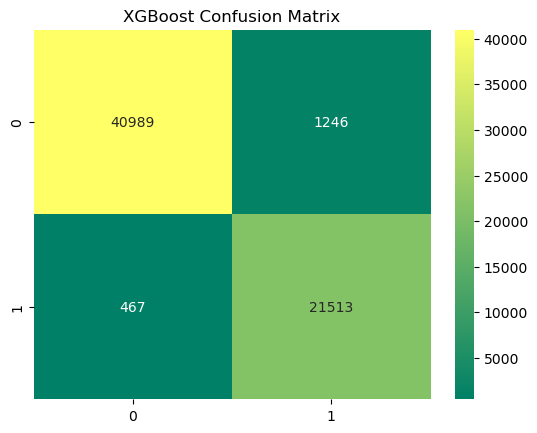

In [153]:
sns.heatmap(metrics.confusion_matrix(y_pred, y_test), annot=True, fmt='2.0f', cmap='summer').set(title="XGBoost Confusion Matrix");

# 7. Conclusion
From the above project, we trained our model using XGBoost algorithm with 98.31% accuracy.

# Prediction

In [154]:
def getPredictions(martial, house_O, car_O, profession, current_jy, current_hy, income, age):
    model_uri = 'runs:/aee56dbb7fb742f6960dcf096f63b398/model'

    model = mlflow.sklearn.load_model(model_uri = model_uri)
    encoders = load(open('./Models/encoders.pkl', 'rb'))

    categorical_data = [martial, house_O, car_O, profession]
    for i, j in enumerate(categorical_data):
        categorical_data[i] = [j]
    categorical_columns = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession']

    for i, column in enumerate(categorical_columns):
        label_encoder = encoders[column]
        categorical_data[i] = label_encoder.transform(categorical_data[i])
     
    categorical_data = np.squeeze(categorical_data)

    if income <= 2506726:
        income = 0
    elif 2506726 < income <= 5003310:
        income = 1
    elif 5003310 < income <=7477502:
        income = 2
    else:
        income = 3

    if age <= 32:
        age = 0
    elif 32 < age <= 44:
        age = 1
    elif 44 < age <= 56:
        age = 2
    elif 56 < age <= 68:
        age = 3
    else:
        age = 4   
        
    data = [[categorical_data[0], categorical_data[1], categorical_data[2], categorical_data[3], current_jy, current_hy, income, age]]
    df = pd.DataFrame(data , columns = model.feature_names_in_)
        
    prediction = model.predict(df)
    if prediction == 0:
        return 'eligible'
    elif prediction == 1:
        return 'not eligible'
    else:
        return 'error'

In [155]:
getPredictions('married', 'owned', 'no', 'Software_Developer', 3, 11, 3600000, 23)

'not eligible'

In [156]:
getPredictions('single', 'rented', 'no', 'Mechanical_engineer', 3, 13, 1303834, 23)

'eligible'

In [157]:
getPredictions('married', 'owned', 'yes', 'Lawyer', 13, 13, 30000000, 80)

'not eligible'

In [159]:
getPredictions('single', 'rented', 'yes', 'Lawyer', 13, 13, 30000000, 80)

'eligible'